
#Užduotis

Antroje užduotyje reikia realizuoti vaizdų klasifikavimo modelį. Atsiskaitinėjant pratybų dėstytojas atsiųs testinių vaizdų, su kuriais turėsite pademonstruoti, kaip jūsų realizuotas modelis veikia. Atsiskaitymo metu, turėsite gebėti papasakoti, kaip realizuotas, jūsų modelis. Programinės įrangos sprendimą galite naudoti savo nuožiūra.

Klasės pasirenkamos savo nuožiūra, tačiau jų turi būti bent 3.
Duomenų rinkinys turi būti padalintas į mokymo ir testavimo aibes.
Su testavimo duomenų aibe reikia paskaičiuoti šias metrikas: klasifikavimo matrica (angl. confusion matrix), tikslumas, precizija, atkūrimas ir F1.
Duomenų klasėms parinktos iš OpenImages V6 objektų aptikimo uždavinio duomenų rinkinio.

In [ ]:
!pip install openimages

In [4]:
import os
os.chdir("/content")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from openimages.download import download_dataset

In [7]:
# Patikrinama, ar yra GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')


Device: cpu


In [15]:
#Atsisiunčiu duomenis iš V6 Open Images
base_path = "/content/drive/MyDrive/gmm2/data2/"

def Download(path):
    download_dir = base_path + path
    download_amount_per_class = 300
    if not os.path.isdir(download_dir):
        download_dataset(download_dir, ["Dog", "Cat", "Horse"], limit=download_amount_per_class)

Download("train")
Download("test")

100%|██████████| 300/300 [00:06<00:00, 44.19it/s]


In [16]:
#Pasitikrinu ar tikrai tiek kiek turėjo klasių susikūrė
data_dir_path = "/content/drive/MyDrive/gmm2/data2/train"
image_classes = os.listdir(data_dir_path)
classes_amount = len(image_classes)
classes_amount

3

In [17]:
# Transformuoju duomenis (augmentacijos)

#1)Treniravimo datasetą:
transforms_train = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
  transforms.RandomRotation(15),
  transforms.RandomGrayscale(),
  transforms.ColorJitter(0.2, 0.3, 0.2)
])

#1)Testavimo datasetą:
transforms_test = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [18]:
#Pasirenku bečo dydį ir paraleliai kiek eis bečų
num_workers = 2
batch_size = 16

# Užkraunu/sutvarkau duomenis:
#1) Mokymosi duomenys
train_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/gmm2/data2/train', transform=transforms_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# 2)Testavimo duomenis
test_dataset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/gmm2/data2/test', transform=transforms_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

#Pažiūrėjimui ar gerai padalinta
classes = ("Cat", "Dog", "Horse")
print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')

Train: 900, Test: 900


In [19]:
#Didesnis konvoliucinis tinklas
class ComplexConvNet(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 16, 3, padding = 'same')
    self.conv1_2 = torch.nn.Conv2d(16, 16, 3, padding = 'same')
    self.pool1 = torch.nn.MaxPool2d((2, 2), (2, 2))
    self.conv2_1 = torch.nn.Conv2d(16, 32, 3, padding = 'same')
    self.conv2_2 = torch.nn.Conv2d(32, 32, 3, padding = 'same')
    self.pool2 = torch.nn.MaxPool2d((2, 2), (2, 2))
    self.fc3 = torch.nn.Linear(32 * in_shape[1] * in_shape[2] // 4**2, 128)
    self.fc4 = torch.nn.Linear(128, out_classes)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.ReLU(),
        self.conv1_2,
        torch.nn.ReLU(),
        self.pool1,
        self.conv2_1,
        torch.nn.ReLU(),
        self.conv2_2,
        torch.nn.ReLU(),
        self.pool2,
        torch.nn.Flatten(),
        self.fc3,
        torch.nn.ReLU(),
        self.fc4
    )(x)
    return y


In [20]:
def train(model, loader, classes, epoch_count, lr=1e-3):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.train()

  start_time = datetime.now()

  for epoch in range(epoch_count):
    loss_values = np.array([], dtype = np.float32)
    correct = 0
    total = 0

    for data in loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      pred = model(images)
      loss = loss_func(pred, labels)
      loss_values = np.append(loss_values, loss.cpu().detach().numpy())

      loss.backward()
      optimizer.step()

      _, predicted = torch.max(pred.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    epoch_loss = np.mean(loss_values)
    epoch_accuracy = correct / total * 100
    current_time = datetime.now()
    elapsed_time = (current_time - start_time).total_seconds()

    print(f'Epoch {epoch + 1}/{epoch_count}, Loss: {epoch_loss:.4f}, '
          f'Accuracy: {epoch_accuracy:.2f}%, Time: {elapsed_time:.2f}s')

In [ ]:
# import os
# import torch

#Pasižiūriu ar viskas gerai su failais
saved_model_path = '/content/drive/MyDrive/gmm2/models/last_model.pth'
os.makedirs(os.path.dirname(saved_model_path), exist_ok=True)

#Bandome tinklą
class_count = len(train_dataset.classes)
model = ComplexConvNet(train_dataset[0][0].shape, class_count).to(device)

# Užloadinam svorius (jei jie egzistuoja)
if os.path.exists(saved_model_path):
    model.load_state_dict(torch.load(saved_model_path, map_location=torch.device(device)))

train(model, train_loader, class_count, epoch_count = 20)

# Išsaugau pratreniruotą modlį atskirai
torch.save(model.state_dict(), saved_model_path)


Epoch 1/20, Loss: 1.0669, Accuracy: 42.11%, Time: 46.55s
Epoch 2/20, Loss: 1.0326, Accuracy: 44.89%, Time: 81.45s
Epoch 3/20, Loss: 1.0087, Accuracy: 46.78%, Time: 119.33s
Epoch 4/20, Loss: 0.9996, Accuracy: 47.56%, Time: 155.05s


In [43]:
# Modelio testavimas
model.load_state_dict(torch.load(saved_model_path))
model.eval()

final_predictions, final_labels = [], []

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Gauna prognozes
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Prognozuotos ir teisingos žymės
    final_predictions.extend(predicted.cpu().numpy())
    final_labels.extend(labels.cpu().numpy())

Precision: 0.5393
Recall: 0.5369
F1: 0.5378
Accuracy: 0.5369


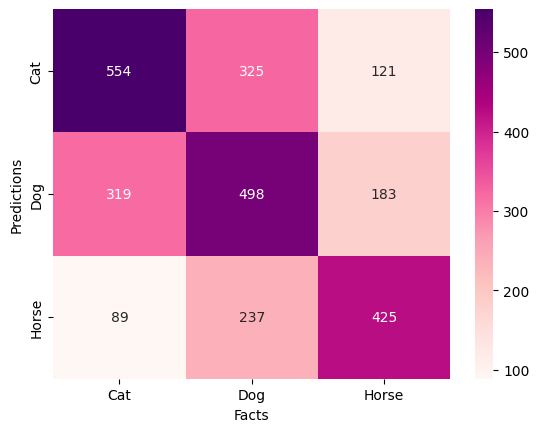

In [51]:
#Confusion matrix
conf_matrix = confusion_matrix(final_labels, final_predictions)

#Precision
precision = precision_score(final_labels, final_predictions, average='weighted')
print(f'Precision: {precision:.4f}')

#Recall
recall = recall_score(final_labels, final_predictions, average='weighted')
print(f'Recall: {recall:.4f}')

#F1
f1 = f1_score(final_labels, final_predictions, average='weighted')
print(f'F1: {f1:.4f}')

#Accuracy
accuracy = accuracy_score(final_labels, final_predictions)
print(f'Accuracy: {accuracy:.4f}')

#
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='RdPu', xticklabels=classes, yticklabels=classes)
plt.xlabel('Facts')
plt.ylabel('Predictions')
plt.show()